# Using GPUs & TPUs with TF-Agents

## Load notebook config

* use the prefix defined in `00-env-setup`

In [1]:
# PREFIX = 'mabv1'
VERSION        = "v2"                       # TODO
PREFIX         = f'rec-bandits-{VERSION}'   # TODO

print(f"PREFIX: {PREFIX}")

PREFIX: rec-bandits-v2


In [2]:
# staging GCS
GCP_PROJECTS             = !gcloud config get-value project
PROJECT_ID               = GCP_PROJECTS[0]

# GCS bucket and paths
BUCKET_NAME              = f'{PREFIX}-{PROJECT_ID}-bucket'
BUCKET_URI               = f'gs://{BUCKET_NAME}'

config = !gsutil cat {BUCKET_URI}/config/notebook_env.py
print(config.n)
exec(config.n)


PROJECT_ID               = "hybrid-vertex"
PROJECT_NUM              = "934903580331"
LOCATION                 = "us-central1"

REGION                   = "us-central1"
BQ_LOCATION              = "US"
VPC_NETWORK_NAME         = "ucaip-haystack-vpc-network"

VERTEX_SA                = "934903580331-compute@developer.gserviceaccount.com"

PREFIX                   = "rec-bandits-v2"
VERSION                  = "v2"

BUCKET_NAME              = "rec-bandits-v2-hybrid-vertex-bucket"
BUCKET_URI               = "gs://rec-bandits-v2-hybrid-vertex-bucket"
DATA_GCS_PREFIX          = "data"
DATA_PATH                = "gs://rec-bandits-v2-hybrid-vertex-bucket/data"
VOCAB_SUBDIR             = "vocabs"
VOCAB_FILENAME           = "vocab_dict.pkl"

VPC_NETWORK_FULL         = "projects/934903580331/global/networks/ucaip-haystack-vpc-network"

BIGQUERY_DATASET_ID      = "hybrid_vertex.movielens_ds_rec_bandits_v2"
BIGQUERY_TABLE_ID        = "hybrid_vertex.movielens_ds_rec_bandits_v2.training_dataset"

REPO

### imports

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [4]:
import functools
from collections import defaultdict
from typing import Callable, Dict, List, Optional, TypeVar
from datetime import datetime
import time
from pprint import pprint
import pickle as pkl

# logging
import logging
logging.disable(logging.WARNING)

import matplotlib.pyplot as plt
import numpy as np

# google cloud
from google.cloud import aiplatform as vertex_ai
from google.cloud import storage

# tensorflow
import tensorflow as tf

from tf_agents.bandits.metrics import tf_metrics as tf_bandit_metrics
from tf_agents.metrics import tf_metrics

from tf_agents.bandits.agents import neural_epsilon_greedy_agent
from tf_agents.bandits.agents import neural_linucb_agent
from tf_agents.bandits.networks import global_and_arm_feature_network

from tf_agents.specs import tensor_spec
from tf_agents.trajectories import time_step as ts
from tf_agents.bandits.policies import policy_utilities
from tf_agents.trajectories import trajectory
from tf_agents.policies import policy_saver

from tf_agents.bandits.specs import utils as bandit_spec_utils
from tf_agents.train.utils import spec_utils
from tf_agents.train.utils import strategy_utils
from tf_agents.train.utils import train_utils

# GPU
from numba import cuda 
import gc

import sys
sys.path.append("..")

# this repo
from src.per_arm_rl import data_utils
from src.per_arm_rl import data_config
from src.per_arm_rl import train_utils as train_utils

# tf exceptions and vars
if tf.__version__[0] != "2":
    raise Exception("The trainer only runs with TensorFlow version 2.")

T = TypeVar("T")

In [5]:
from src.perarm_features import agent_factory as agent_factory
from src.perarm_features import reward_factory as reward_factory
from src.perarm_features import emb_features as emb_features

In [6]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [7]:
device = cuda.get_current_device()
device.reset()
gc.collect()

14

In [8]:
# cloud storage client
storage_client = storage.Client(project=PROJECT_ID)

# Vertex client
vertex_ai.init(project=PROJECT_ID, location=LOCATION)

### Generate Vocabs

In [9]:
GENERATE_VOCABS = False

print(f"GENERATE_VOCABS: {GENERATE_VOCABS}")

GENERATE_VOCABS: False


In [10]:
if not GENERATE_VOCABS:

    EXISTING_VOCAB_FILE = f'gs://{BUCKET_NAME}/{VOCAB_SUBDIR}/{VOCAB_FILENAME}'
    print(f"Downloading vocab...")
    
    os.system(f'gsutil -q cp {EXISTING_VOCAB_FILE} .')
    print(f"Downloaded vocab from: {EXISTING_VOCAB_FILE}\n")

    filehandler = open(VOCAB_FILENAME, 'rb')
    VOCAB_DICT = pkl.load(filehandler)
    filehandler.close()
    
    for key in VOCAB_DICT.keys():
        pprint(key)

Downloaded vocab from: gs://rec-bandits-v2-hybrid-vertex-bucket/vocabs/vocab_dict.pkl

'movie_id'
'user_id'
'user_occupation_text'
'movie_genres'
'bucketized_user_age'
'max_timestamp'
'min_timestamp'
'timestamp_buckets'


### train config

In [11]:
NUM_OOV_BUCKETS        = 1
GLOBAL_EMBEDDING_SIZE  = 16
MV_EMBEDDING_SIZE      = 32 #32

GLOBAL_DIM             = 64
PER_ARM_DIM            = 64

BATCH_SIZE             = 256
EVAL_BATCH_SIZE        = 1
NUM_ACTIONS            = 2 
#this is kinda deceptive - 
#our approach is to learn by "flashing" one movie rating at a time per user context. 
#The n_actions = show/don't show the movie with one degree of freedom (n-1)

print(f"NUM_OOV_BUCKETS        : {NUM_OOV_BUCKETS}")
print(f"GLOBAL_EMBEDDING_SIZE  : {GLOBAL_EMBEDDING_SIZE}")
print(f"MV_EMBEDDING_SIZE      : {MV_EMBEDDING_SIZE}")
print(f"GLOBAL_DIM             : {GLOBAL_DIM}")
print(f"PER_ARM_DIM            : {PER_ARM_DIM}")
print(f"BATCH_SIZE             : {BATCH_SIZE}")
print(f"EVAL_BATCH_SIZE        : {EVAL_BATCH_SIZE}")
print(f"NUM_ACTIONS            : {NUM_ACTIONS}")

NUM_OOV_BUCKETS        : 1
GLOBAL_EMBEDDING_SIZE  : 16
MV_EMBEDDING_SIZE      : 32
GLOBAL_DIM             : 64
PER_ARM_DIM            : 64
BATCH_SIZE             : 256
EVAL_BATCH_SIZE        : 1
NUM_ACTIONS            : 2


#### confirm GLOBAL and PER_ARM DIMs

In [12]:
# options = tf.data.Options()
# options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.AUTO

SPLIT = "train" # "train" | "val"

train_files = []
for blob in storage_client.list_blobs(f"{BUCKET_NAME}", prefix=f'{DATA_GCS_PREFIX}/{SPLIT}'):
    if '.tfrecord' in blob.name:
        train_files.append(blob.public_url.replace("https://storage.googleapis.com/", "gs://"))
        
train_dataset = tf.data.TFRecordDataset(train_files)
train_dataset = train_dataset.map(data_utils.parse_tfrecord)

In [13]:
for i in range(1):
    
    iterator = iter(train_dataset.batch(1))
    data = next(iterator)

data

{'bucketized_user_age': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([35.], dtype=float32)>,
 'movie_genres': <tf.Tensor: shape=(1, 1), dtype=int64, numpy=array([[7]])>,
 'movie_id': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'898'], dtype=object)>,
 'timestamp': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([885409515])>,
 'user_id': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'681'], dtype=object)>,
 'user_occupation_text': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'marketing'], dtype=object)>,
 'user_rating': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([4.], dtype=float32)>}

In [14]:
embs = emb_features.EmbeddingModel(
    vocab_dict = VOCAB_DICT,
    num_oov_buckets = NUM_OOV_BUCKETS,
    global_emb_size = GLOBAL_EMBEDDING_SIZE,
    mv_emb_size = MV_EMBEDDING_SIZE,
)

embs

In [15]:
test_globals = embs._get_global_context_features(data)

GLOBAL_DIM = test_globals.shape[1]            
# shape checks out at batch_dim, nactions, arm feats
print(f"GLOBAL_DIM: {GLOBAL_DIM}")

test_globals

GLOBAL_DIM: 64


array([[ 0.00462369,  0.0344087 , -0.03753804,  0.0465712 , -0.0449583 ,
        -0.00762995,  0.04358158,  0.04707915, -0.04449252, -0.04994837,
        -0.00614621,  0.0350021 ,  0.03235538, -0.03708299,  0.0138814 ,
         0.04825223, -0.00314816,  0.01638681, -0.01673931,  0.04389663,
        -0.03573678, -0.01526792, -0.00665609, -0.00798749,  0.04566279,
        -0.04242706,  0.02629404,  0.02170688, -0.01217309, -0.03795565,
        -0.00251526,  0.00219245,  0.02092954,  0.02189329, -0.02327817,
         0.04993096, -0.00355359,  0.04853803, -0.02521833, -0.02342535,
        -0.01472504, -0.00184758,  0.02520795, -0.0229484 ,  0.02893383,
        -0.02101078,  0.01355273,  0.02794279, -0.00761303,  0.01583053,
         0.02387163,  0.01422511, -0.03142186,  0.0357598 , -0.01988267,
         0.00763677, -0.03971846,  0.02193639,  0.0093832 , -0.04101249,
        -0.03535876, -0.00780011,  0.01397982,  0.00868108]],
      dtype=float32)

In [16]:
test_arms = embs._get_per_arm_features(data)

PER_ARM_DIM = test_arms.shape[1]            
# shape checks out at batch_dim, nactions, arm feats
print(f"PER_ARM_DIM: {PER_ARM_DIM}")

test_arms

PER_ARM_DIM: 64


array([[-0.03046641,  0.02454836,  0.03536471,  0.01529981,  0.04641232,
        -0.02767863,  0.00180705,  0.02776461, -0.03147535, -0.02429341,
        -0.04527265,  0.03496535,  0.02293259, -0.03972387, -0.04783459,
        -0.04022413, -0.01573253,  0.00535781,  0.01871845,  0.02044563,
         0.00433677,  0.01929047, -0.03219631, -0.03660736, -0.00841188,
         0.02041255,  0.01044059, -0.03995557, -0.03006003,  0.0022236 ,
         0.04102707, -0.02041341,  0.03413859, -0.02025267, -0.02215879,
        -0.03325437,  0.02773179,  0.03266391,  0.02458663,  0.01096087,
         0.03245436, -0.0206298 , -0.03138905, -0.01230401,  0.00668992,
        -0.04382006, -0.00372628,  0.02546184, -0.00906253, -0.01383702,
         0.0340375 , -0.03598855, -0.01955246,  0.01362151, -0.03588787,
        -0.00635668, -0.01228255, -0.01530866, -0.01570983,  0.04076118,
        -0.02284696, -0.04391026,  0.0078168 , -0.01186331]],
      dtype=float32)

### TensorSpecs

In [17]:
observation_spec = {
    'global': tf.TensorSpec([GLOBAL_DIM], tf.float32),
    'per_arm': tf.TensorSpec([NUM_ACTIONS, PER_ARM_DIM], tf.float32) #excluding action dim here
}
observation_spec

{'global': TensorSpec(shape=(64,), dtype=tf.float32, name=None),
 'per_arm': TensorSpec(shape=(2, 64), dtype=tf.float32, name=None)}

In [18]:
action_spec = tensor_spec.BoundedTensorSpec(
    shape=[], 
    dtype=tf.int32,
    minimum=tf.constant(0),            
    maximum=NUM_ACTIONS-1, # n degrees of freedom and will dictate the expected mean reward spec shape
    name="action_spec"
)

action_spec

BoundedTensorSpec(shape=(), dtype=tf.int32, name='action_spec', minimum=array(0, dtype=int32), maximum=array(1, dtype=int32))

In [19]:
time_step_spec = ts.time_step_spec(
    observation_spec = observation_spec, 
    # reward_spec = _reward_spec
)
time_step_spec

TimeStep(
{'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'observation': {'global': TensorSpec(shape=(64,), dtype=tf.float32, name=None),
                 'per_arm': TensorSpec(shape=(2, 64), dtype=tf.float32, name=None)},
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})

## Distribution strategy

Use `strategy_utils` to generate a strategy. Under the hood, passing the parameter:

* `use_gpu = False` returns `tf.distribute.get_strategy()`, which uses CPU
* `use_gpu = True` returns `tf.distribute.MirroredStrategy()`, which uses all GPUs that are visible to TensorFlow on one machine

In [20]:
use_gpu = True
use_tpu = False

distribution_strategy = strategy_utils.get_strategy(tpu=use_tpu, use_gpu=use_gpu)
distribution_strategy

In [21]:
NUM_REPLICAS = distribution_strategy.num_replicas_in_sync
NUM_REPLICAS

1

In [22]:
# distribution_strategy = tf.distribute.MirroredStrategy()
# distribution_strategy

In [23]:
# distribution_strategy.cluster_resolver.

In [24]:
# tf.distribute.get_strategy()

### Config

In [25]:
# ================================
# Agents
# ================================
AGENT_TYPE      = 'epsGreedy' # 'LinUCB' | 'LinTS |, 'epsGreedy' | 'NeuralLinUCB'

# Parameters for linear agents (LinUCB and LinTS).
AGENT_ALPHA     = 0.1

# Parameters for neural agents (NeuralEpsGreedy and NerualLinUCB).
EPSILON         = 0.01
LR              = 0.05

# Parameters for NeuralLinUCB
ENCODING_DIM    = 1
EPS_PHASE_STEPS = 1000

NUM_EVAL_STEPS = 10000

# ================================
# Agent's Preprocess Network
# ================================
NETWORK_TYPE    = "commontower" # 'commontower' | 'dotproduct'

if AGENT_TYPE == 'NeuralLinUCB':
    NETWORK_TYPE = 'commontower'
    
GLOBAL_LAYERS   = [64, 32, 16]
ARM_LAYERS      = [64, 32, 16]
COMMON_LAYERS   = [16, 8]

HPARAMS = {  # TODO - streamline and consolidate
    "batch_size": BATCH_SIZE,
    "eval_batch_size" : EVAL_BATCH_SIZE,
    "num_actions": NUM_ACTIONS,
    "model_type": AGENT_TYPE,
    "network_type": NETWORK_TYPE,
    "global_layers": GLOBAL_LAYERS,
    "per_arm_layers": ARM_LAYERS,
    "common_layers": COMMON_LAYERS,
    "learning_rate": LR,
    "epsilon": EPSILON,
    "num_eval_steps": NUM_EVAL_STEPS,
}
pprint(HPARAMS)

{'batch_size': 256,
 'common_layers': [16, 8],
 'epsilon': 0.01,
 'eval_batch_size': 1,
 'global_layers': [64, 32, 16],
 'learning_rate': 0.05,
 'model_type': 'epsGreedy',
 'network_type': 'commontower',
 'num_actions': 2,
 'num_eval_steps': 10000,
 'per_arm_layers': [64, 32, 16]}


### trajectory function

In [26]:
def _trajectory_fn(element): # hparams
    
    """Converts a dataset element into a trajectory."""
    # global_features = _get_global_context_features(element)
    # arm_features = _get_per_arm_features(element)
    
    global_features = embs._get_global_context_features(element)
    arm_features = embs._get_per_arm_features(element)
    
    # Adds a time dimension.
    arm_features = train_utils._add_outer_dimension(arm_features)

    # obs spec
    observation = {
        bandit_spec_utils.GLOBAL_FEATURE_KEY:
            train_utils._add_outer_dimension(global_features),
    }

    reward = train_utils._add_outer_dimension(reward_factory._get_rewards(element))

    # To emit the predicted rewards in policy_info, we need to create dummy
    # rewards to match the definition in TensorSpec for the ones specified in
    # emit_policy_info set.
    dummy_rewards = tf.zeros([HPARAMS['batch_size'], 1, HPARAMS['num_actions']])
    policy_info = policy_utilities.PerArmPolicyInfo(
        chosen_arm_features=arm_features,
        # Pass dummy mean rewards here to match the model_spec for emitting
        # mean rewards in policy info
        predicted_rewards_mean=dummy_rewards,
        bandit_policy_type=tf.zeros([HPARAMS['batch_size'], 1, 1], dtype=tf.int32)
        # policy_utilities.create_bandit_policy_type_tensor_spec(shape=[1]) # policy_utilities.BanditPolicyType.GREEDY
        # tf.zeros([batch_size, 1, 1], dtype=tf.int32)
    )
    
    if HPARAMS['model_type'] == 'neural_ucb':
        policy_info = policy_info._replace(
            predicted_rewards_optimistic=dummy_rewards
        )
        
    return trajectory.single_step(
        observation=observation,
        action=tf.zeros_like(
            reward, dtype=tf.int32
        ),  # Arm features are copied from policy info, put dummy zeros here
        policy_info=policy_info,
        reward=reward,
        discount=tf.zeros_like(reward)
    )

#### debugging - uncomment to view shapes n' dims

In [27]:
# for x in train_dataset.batch(HPARAMS['batch_size']).take(1):
#     test_traj_v1 = _trajectory_fn(x)
    
# test_traj_v1

In [28]:
# print(f"test_traj_v1.action.shape: {test_traj_v1.action.shape}") 

In [29]:
# print(f"test_traj_v1.discount.shape: {test_traj_v1.discount.shape}") 

In [30]:
# print(f"test_traj_v1.observation.shape: {test_traj_v1.observation['global'].shape}") 

In [31]:
# print(f"test_traj_v1.reward.shape: {test_traj_v1.reward.shape}") 

### Create Agent

> Note: writting distributions and historgrams of gradients and variables will negatively impact training performance

* set `summarize_grads_and_vars = False` for best training performance
* keep `debug_summaries = True` to track training metrics (e.g., loss / regret)

In [32]:
with distribution_strategy.scope():
    
    global_step = tf.compat.v1.train.get_or_create_global_step()
    # global_step = train_utils.create_train_step()
    
    agent = agent_factory.PerArmAgentFactory._get_agent(
        agent_type = AGENT_TYPE,
        network_type = NETWORK_TYPE,
        time_step_spec = time_step_spec,
        action_spec = action_spec,
        observation_spec=observation_spec,
        global_layers = GLOBAL_LAYERS,
        arm_layers = ARM_LAYERS,
        common_layers = COMMON_LAYERS,
        agent_alpha = AGENT_ALPHA,
        learning_rate = LR,
        epsilon = EPSILON,
        train_step_counter = global_step,
        output_dim = ENCODING_DIM,
        eps_phase_steps = EPS_PHASE_STEPS,
        summarize_grads_and_vars = False,
        debug_summaries = True
    )
    
agent.initialize()

print(f"Agent: {agent.name}")

if NETWORK_TYPE:
    print(f"NETWORK_TYPE: {NETWORK_TYPE}")

Agent: NeuralEpsGreedyAgent
NETWORK_TYPE: commontower


In [33]:
global_step

MirroredVariable:{
  0: <tf.Variable 'global_step:0' shape=() dtype=int64, numpy=0>
}

#### Inspect shapes

In [34]:
agent.action_spec

BoundedTensorSpec(shape=(), dtype=tf.int32, name='action_spec', minimum=array(0, dtype=int32), maximum=array(1, dtype=int32))

In [35]:
agent.time_step_spec

_TupleWrapper(TimeStep(
{'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'observation': DictWrapper({'global': TensorSpec(shape=(64,), dtype=tf.float32, name=None), 'per_arm': TensorSpec(shape=(2, 64), dtype=tf.float32, name=None)}),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')}))

In [36]:
agent.training_data_spec

_TupleWrapper(Trajectory(
{'action': BoundedTensorSpec(shape=(), dtype=tf.int32, name='action_spec', minimum=array(0, dtype=int32), maximum=array(1, dtype=int32)),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': DictWrapper({'global': TensorSpec(shape=(64,), dtype=tf.float32, name=None)}),
 'policy_info': PerArmPolicyInfo(log_probability=(), predicted_rewards_mean=TensorSpec(shape=(2,), dtype=tf.float32, name=None), multiobjective_scalarized_predicted_rewards_mean=(), predicted_rewards_optimistic=(), predicted_rewards_sampled=(), bandit_policy_type=BoundedTensorSpec(shape=(1,), dtype=tf.int32, name=None, minimum=array(0, dtype=int32), maximum=array(4, dtype=int32)), chosen_arm_features=TensorSpec(shape=(64,), dtype=tf.float32, name=None)),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward

### GPU stuff

* `TF_GPU_THREAD_MODE=gpu_private` ensures that GPU kernels are launched from their own dedicated threads, and don't get queued behind tf.data work.

In [37]:
import os

TF_GPU_THREAD_COUNT   = '4'      # '1' | '4' | '8'

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_GPU_THREAD_MODE']='gpu_private'
os.environ['TF_GPU_THREAD_COUNT']=f"{TF_GPU_THREAD_COUNT}"
os.environ['TF_GPU_ALLOCATOR']='cuda_malloc_async'

## Vertex Experiment

In [38]:
EXPERIMENT_NAME   = f'v3-acc-input-data-v1'

# new experiment
invoke_time       = time.strftime("%Y%m%d-%H%M%S")
RUN_NAME          = f'run-{invoke_time}'

BASE_OUTPUT_DIR   = f'{BUCKET_URI}/{EXPERIMENT_NAME}/{RUN_NAME}'
LOG_DIR           = f"{BASE_OUTPUT_DIR}/logs"
ROOT_DIR          = f"{BASE_OUTPUT_DIR}/root"       # Root directory for writing logs/summaries/checkpoints.
ARTIFACTS_DIR     = f"{BASE_OUTPUT_DIR}/artifacts"  # Where the trained model will be saved and restored.

vertex_ai.init(
    project=PROJECT_ID,
    location=REGION,
    experiment=EXPERIMENT_NAME
)

print(f"EXPERIMENT_NAME   : {EXPERIMENT_NAME}")
print(f"RUN_NAME          : {RUN_NAME}\n")
print(f"BASE_OUTPUT_DIR   : {BASE_OUTPUT_DIR}")
print(f"LOG_DIR           : {LOG_DIR}")
print(f"ROOT_DIR          : {ROOT_DIR}")
print(f"ARTIFACTS_DIR     : {ARTIFACTS_DIR}")

EXPERIMENT_NAME   : v3-acc-input-data-v1
RUN_NAME          : run-20231017-205232

BASE_OUTPUT_DIR   : gs://rec-bandits-v2-hybrid-vertex-bucket/v3-acc-input-data-v1/run-20231017-205232
LOG_DIR           : gs://rec-bandits-v2-hybrid-vertex-bucket/v3-acc-input-data-v1/run-20231017-205232/logs
ROOT_DIR          : gs://rec-bandits-v2-hybrid-vertex-bucket/v3-acc-input-data-v1/run-20231017-205232/root
ARTIFACTS_DIR     : gs://rec-bandits-v2-hybrid-vertex-bucket/v3-acc-input-data-v1/run-20231017-205232/artifacts


In [39]:
# ====================================================
# TB summary writer
# ====================================================
with distribution_strategy.scope():
    train_summary_writer = tf.compat.v2.summary.create_file_writer(
        f"{LOG_DIR}/train", flush_millis=10 * 1000
    )

    train_summary_writer.set_as_default()

## Train loops

In [40]:
from src.perarm_features import train_perarm as train_perarm

NUM_ITER_STEPS       = 100
STEPS_PER_LOOP       = 1
LOG_INTERVAL         = 10
CHKPT_INTERVAL       = 200
NUM_EVAL_STEPS       = 100
ASYNC_STEPS_PER_LOOP = 1

print(f"NUM_ITER_STEPS       : {NUM_ITER_STEPS}")       #  = 50
print(f"STEPS_PER_LOOP       : {STEPS_PER_LOOP}")       #  = 1
print(f"LOG_INTERVAL         : {LOG_INTERVAL}")         #  = 10
print(f"CHKPT_INTERVAL       : {CHKPT_INTERVAL}")       #  = 200
print(f"NUM_EVAL_STEPS       : {NUM_EVAL_STEPS}")       #  = 100
print(f"ASYNC_STEPS_PER_LOOP : {ASYNC_STEPS_PER_LOOP}") # = 1

NUM_ITER_STEPS       : 100
STEPS_PER_LOOP       : 1
LOG_INTERVAL         : 10
CHKPT_INTERVAL       : 200
NUM_EVAL_STEPS       : 100
ASYNC_STEPS_PER_LOOP : 1


In [41]:
TOTAL_TRAIN_TAKE = NUM_ITER_STEPS * HPARAMS['batch_size']
TOTAL_TRAIN_TAKE

25600

In [42]:
#start the timer and training
start_time = time.time()

# Reset the train step
agent.train_step_counter.assign(0)

metric_results, agent = train_perarm.train_perarm(
    agent = agent,
    global_dim = GLOBAL_DIM,
    per_arm_dim = PER_ARM_DIM,
    num_iterations = NUM_ITER_STEPS,
    steps_per_loop = STEPS_PER_LOOP,
    num_eval_steps = NUM_EVAL_STEPS,
    # data
    batch_size = HPARAMS['batch_size'],
    eval_batch_size = HPARAMS['eval_batch_size'],
    # functions
    _trajectory_fn = _trajectory_fn,
    # _run_bandit_eval_fn = _run_bandit_eval,
    # train intervals
    chkpt_interval = CHKPT_INTERVAL,
    log_interval = LOG_INTERVAL,
    # dirs
    bucket_name = BUCKET_NAME,
    data_dir_prefix_path = DATA_GCS_PREFIX,
    log_dir = LOG_DIR,
    model_dir = ARTIFACTS_DIR,
    root_dir = ROOT_DIR,
    async_steps_per_loop = ASYNC_STEPS_PER_LOOP,
    resume_training_loops = False,
    use_gpu = True,
    use_tpu = False,
    profiler = True,
    global_step = global_step,
    total_train_take = TOTAL_TRAIN_TAKE, # TODO - remove?
    train_summary_writer = train_summary_writer,
    # additional_metrics = metrics,
    cache_train_data = False,
)

end_time = time.time()
runtime_mins = int((end_time - start_time) / 60)
print(f"complete train job in {runtime_mins} minutes")

train_files: ['gs://rec-bandits-v2-hybrid-vertex-bucket/data/train/ml-ratings-100k-train.tfrecord']
train_ds_iterator: <tensorflow.python.data.ops.iterator_ops.OwnedIterator object at 0x7f8c30fdfe20>
setting checkpoint_manager: gs://rec-bandits-v2-hybrid-vertex-bucket/v3-acc-input-data-v1/run-20231017-205232/root/chkpoint
wrapping agent.train in tf-function
starting_loop: 0
starting train loop...
step = 0: loss = 15.760000228881836
step = 10: loss = 11.4399995803833
step = 20: loss = 4.070000171661377
step = 30: loss = 1.4700000286102295
step = 40: loss = 1.690000057220459
step = 50: loss = 1.25
step = 60: loss = 1.2200000286102295
step = 70: loss = 1.3300000429153442
step = 80: loss = 1.3300000429153442
step = 90: loss = 1.350000023841858
runtime_mins: 1
saved trained policy to: gs://rec-bandits-v2-hybrid-vertex-bucket/v3-acc-input-data-v1/run-20231017-205232/artifacts
complete train job in 1 minutes


In [43]:
# len(metric_results)
metric_results[-1]

1.3075056

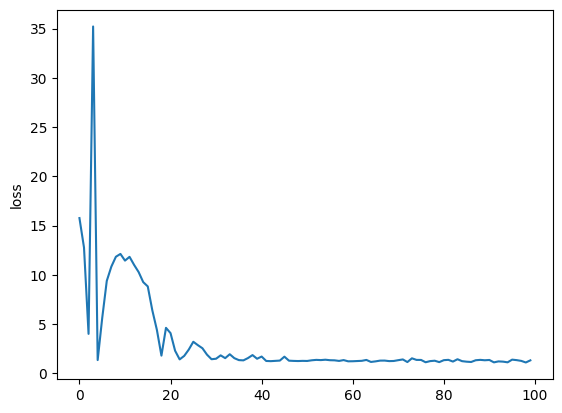

In [44]:
import matplotlib.pyplot as plt

plt.plot(metric_results)
plt.ylabel('loss')
plt.show()

### GPU profiling

#### Load TensorBoard

> on the right-hand side, find `PROFILE` in the drop down:

<img src="imgs/getting_profiler.png" 
     align="center" 
     width="850"
     height="850"/>
     
<!-- tf_vertex_agents/imgs/getting_profiler.png -->

In [45]:
LOG_DIR

'gs://rec-bandits-v2-hybrid-vertex-bucket/v3-acc-input-data-v1/run-20231017-205232/logs'

In [46]:
# %load_ext tensorboard
%reload_ext tensorboard

In [47]:
%tensorboard --logdir=$LOG_DIR 

**Finished**